# Test ComEvalFramework on rings

with fancy plots etc.

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import InvariantSlotAttention

from matplotlib.patches import Circle
import json

# Set numpy seed for test set sampling 
torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

In [3]:
cID_prev = 'isa-scclevr-EncStudy-moreCNN'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [4]:
m = InvariantSlotAttention(**hps)

Using  to encode data.


In [5]:
f = open(f'./../../code/models/{cID_prev}/loss.json')
# returns JSON object as a dictionary
losses = json.load(f)

loss  tot  min:  0.02874750830233097  at  16114
loss  bce  min:  0.00916451308876276  at  17497
loss  mse  min:  0.00608300743624568  at  11845


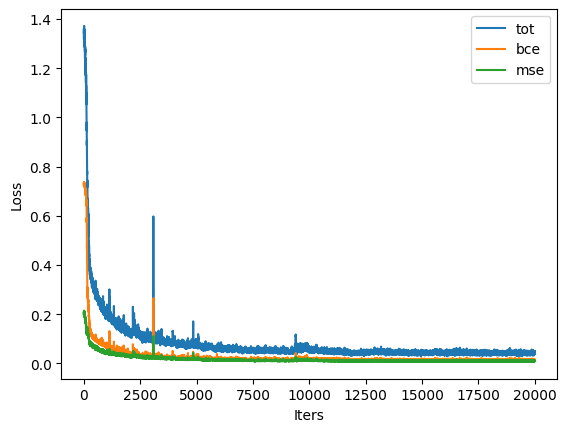

In [6]:
for k,v in losses.items():
    plt.plot(v,label=k)
    print("loss ", k, " min: ", np.min(v), " at ", np.argmin(v))
plt.xlabel('Iters')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
lastIter = 16000
weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 16000


<All keys matched successfully>

### Evaluate the model

Use the common evaluation framework

In [8]:
import scclevr
os.sys.path.append('./../../../evaluation')
from dataset import TestDataset
import model_performance as ev
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
ds = TestDataset()
X = torch.FloatTensor(ds.event_images).to(device)

In [10]:
with torch.no_grad():
    queries, att, Y_pred = m(X) 

In [11]:
mp = ev.Model_performance(ds, att)
mp.hungarian_matching()

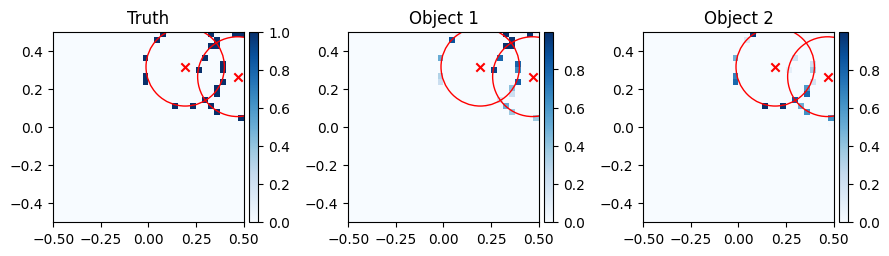

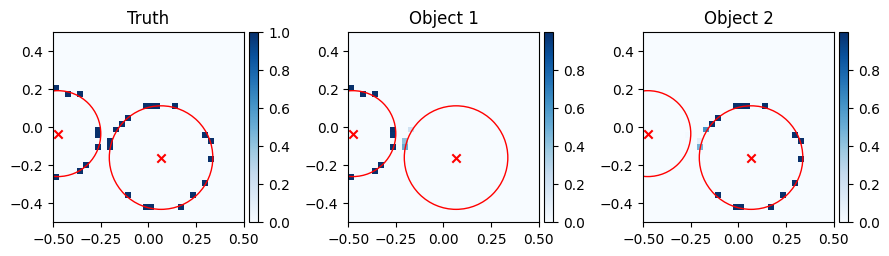

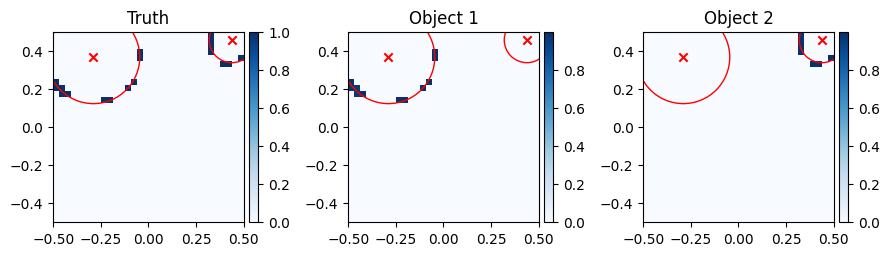

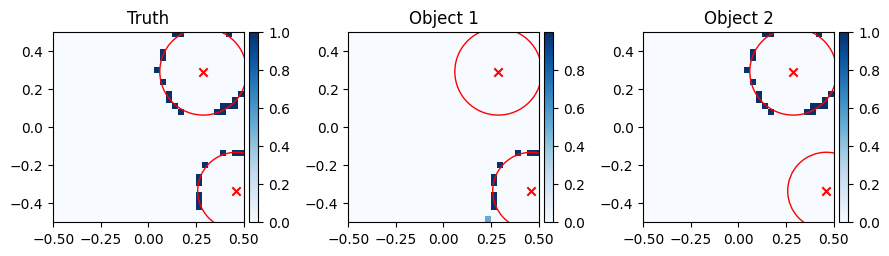

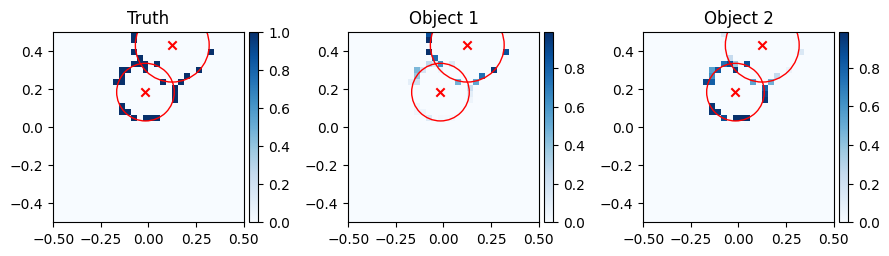

In [15]:
for i in range(5):
    mp.plot_instance_i(i)

In [16]:
loss = mp.KL_loss()
np.log10(loss)

tensor(-3.5213)

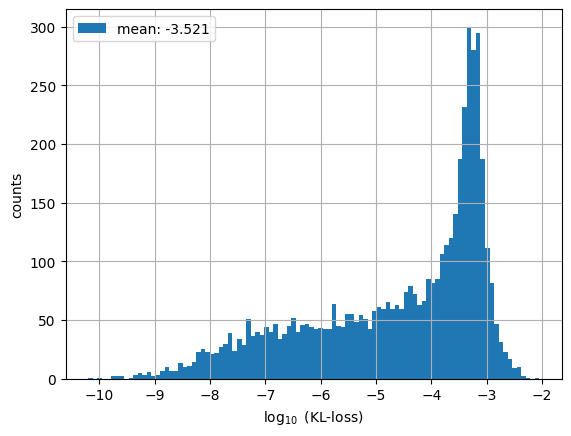

In [17]:
n, edges = mp.loss_hist()

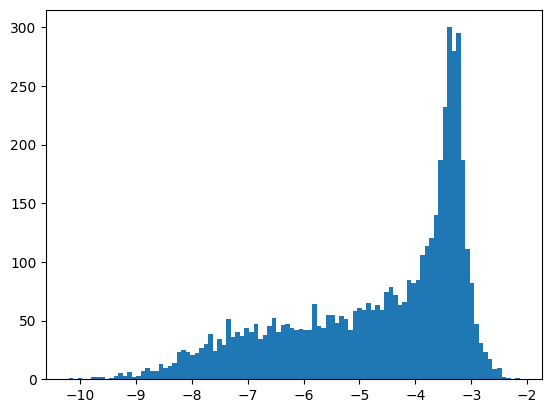

In [18]:
plt.hist(edges[:-1], weights=n, bins=100)
plt.show()

## load an other model and try to compare histograms


In [19]:
cID_prev = 'isa-scclevr-EncStudy-myResNet'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [20]:
m1 = InvariantSlotAttention(**hps)

Using MyResNet to encode data.


In [21]:
lastIter = 9000
weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m1.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 9000


<All keys matched successfully>

In [22]:
with torch.no_grad():
    queries, att, Y_pred = m1(X) 

In [23]:
mp1 = ev.Model_performance(ds, att)
mp1.hungarian_matching()

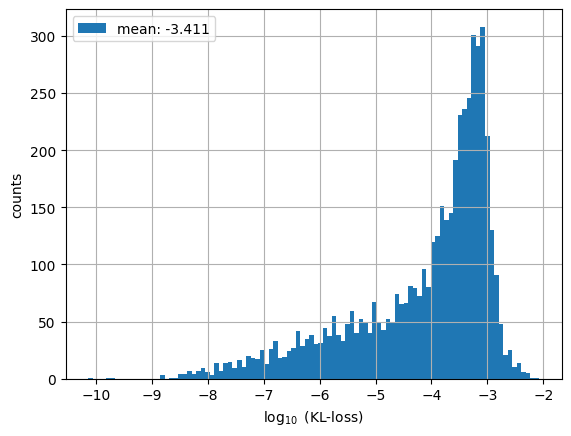

In [24]:
n1, edges1 = mp1.loss_hist()

In [25]:
def compare_histograms(bin_values, bin_edges, labels):
    ''' 
    bin_values have the shape [n, n_bins] where n is the number of histograms to compare
    bin_edges  have the shape [n, n_bins+1] where n is the number of histograms to compare
    labels have the shape [n] where n is the number of histograms to compare.
    '''
    for i in range(bin_values.shape[0]):
        plt.hist(bin_edges[i][:-1], weights=bin_values[i], bins=bin_values.shape[1], alpha=0.55, label=str(labels[i]))
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()

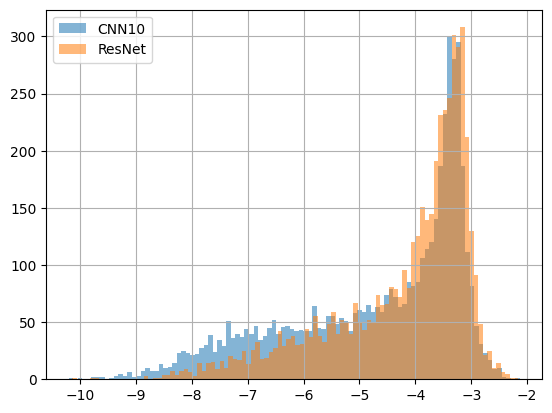

In [26]:
compare_histograms(np.array([n, n1]), np.array([edges, edges1]), labels=np.array(['CNN10', 'ResNet']))

Ok let's consider **Pearson correlation coefficient**

In [27]:
import seaborn as sns

In [28]:
def pearson():
    df = pd.DataFrame()
    df["KL_loss"] =mp.loss_KL.numpy()
    df["x1"] = ds.object_features[:, 0, 0]
    df["x2"] = ds.object_features[:, 1, 0]
    df["y1"] = ds.object_features[:, 0, 1]
    df["y2"] = ds.object_features[:, 1, 1]
    df["r1"] = ds.object_features[:, 0, 2]
    df["r2"] = ds.object_features[:, 1, 2]
    df["r_diff"] = abs(df["r1"]-df["r2"])
    df["distance"] = np.sqrt((df["x2"]-df["x1"])**2 + (df["y2"]-df["y1"])**2)
    df["overlap"] = [True if df["distance"][i]-(df["r1"][i]+df["r2"][i])<0 else False for i in range(df.shape[0])]
    df["log_KL_loss"] = np.nan_to_num(np.log10(df["KL_loss"]))
    
    coeff = df.corr()["KL_loss"].drop("KL_loss").sort_values(ascending=False)
    sns.barplot(coeff)
    plt.xticks(rotation=45)
    plt.show()
    plt.close()
    return coeff

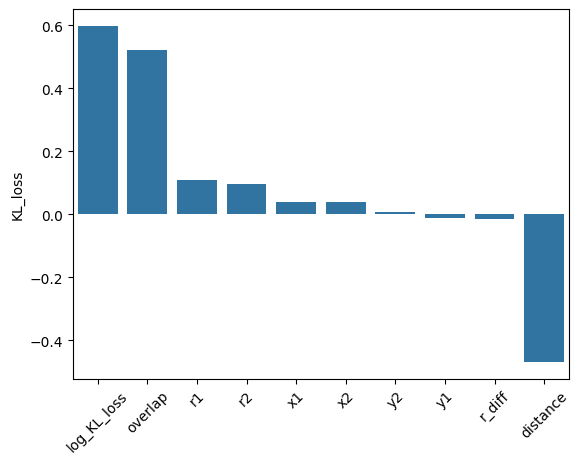

log_KL_loss    0.597595
overlap        0.521800
r1             0.110180
r2             0.094721
x1             0.039145
x2             0.038624
y2             0.007674
y1            -0.010369
r_diff        -0.016308
distance      -0.467927
Name: KL_loss, dtype: float64

In [29]:
pearson()

In [30]:
df = pd.DataFrame()
df["KL_loss"] =mp.loss_KL.numpy()
df["x1"] = ds.object_features[:, 0, 0]
df["x2"] = ds.object_features[:, 1, 0]
df["y1"] = ds.object_features[:, 0, 1]
df["y2"] = ds.object_features[:, 1, 1]
df["r1"] = ds.object_features[:, 0, 2]
df["r2"] = ds.object_features[:, 1, 2]
df["r_diff"] = abs(df["r1"]-df["r2"])
df["distance"] = np.sqrt((df["x2"]-df["x1"])**2 + (df["y2"]-df["y1"])**2)
df["overlap"] = [True if df["distance"][i]-(df["r1"][i]+df["r2"][i])<0 else False for i in range(df.shape[0])]
df["log_KL_loss"] = np.nan_to_num(np.log10(df["KL_loss"]))

<Axes: xlabel='log_KL_loss', ylabel='overlap'>

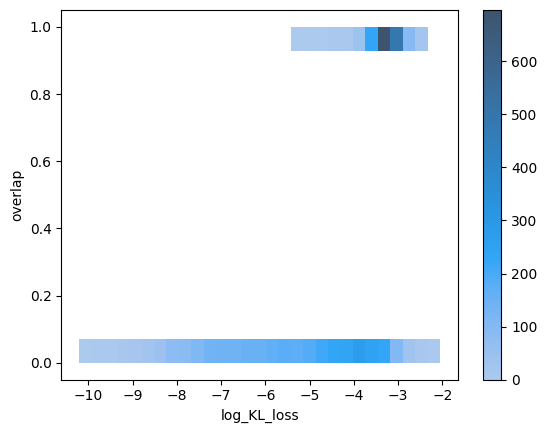

In [31]:
sns.histplot(data=df, x="log_KL_loss", y='overlap', cbar=True )

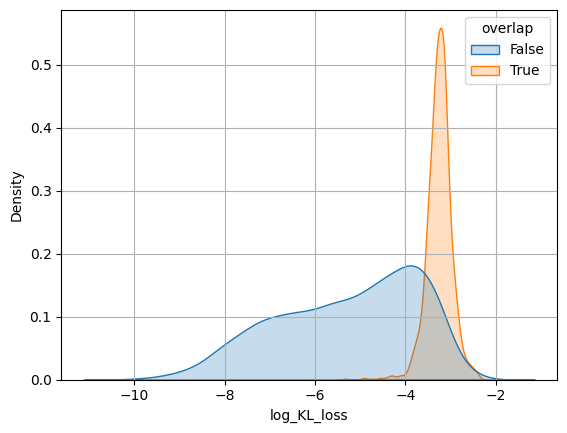

In [32]:
sns.kdeplot(data=df, x='log_KL_loss', hue='overlap', fill=True)
plt.grid()

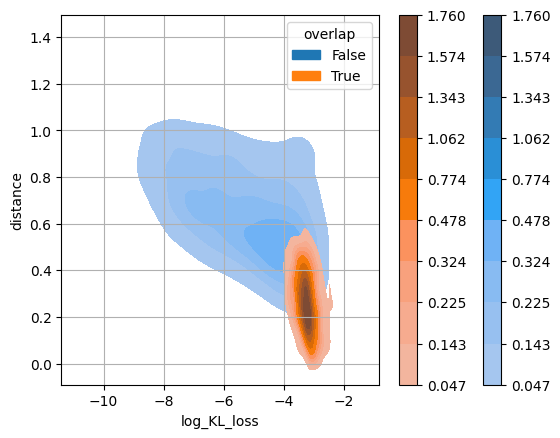

In [33]:
sns.kdeplot(data=df, x='log_KL_loss', y='distance', hue='overlap', fill=True, cbar=True)
plt.grid()

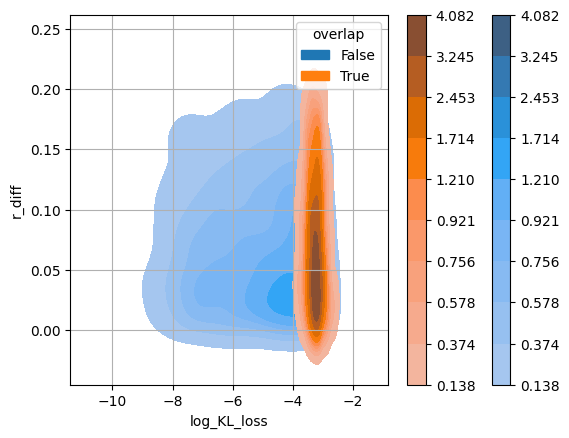

In [34]:
sns.kdeplot(data=df, x='log_KL_loss', y='r_diff', hue='overlap', fill=True, cbar=True)
plt.grid()

In [39]:
def kde_plots():
    fig = plt.figure(figsize=(15,4.5))
    
    plt.subplot(1,3,1)
    sns.kdeplot(data=df, x='log_KL_loss', hue='overlap', fill=True)
    plt.grid()
    
    plt.subplot(1,3,2)
    sns.kdeplot(data=df, x='log_KL_loss', y='distance', hue='overlap', fill=True, cbar=True)
    plt.grid()
    
    plt.subplot(1,3,3)
    sns.kdeplot(data=df, x='log_KL_loss', y='r_diff', hue='overlap', fill=True, cbar=True)
    plt.grid()
    
    plt.tight_layout()
    plt.show()

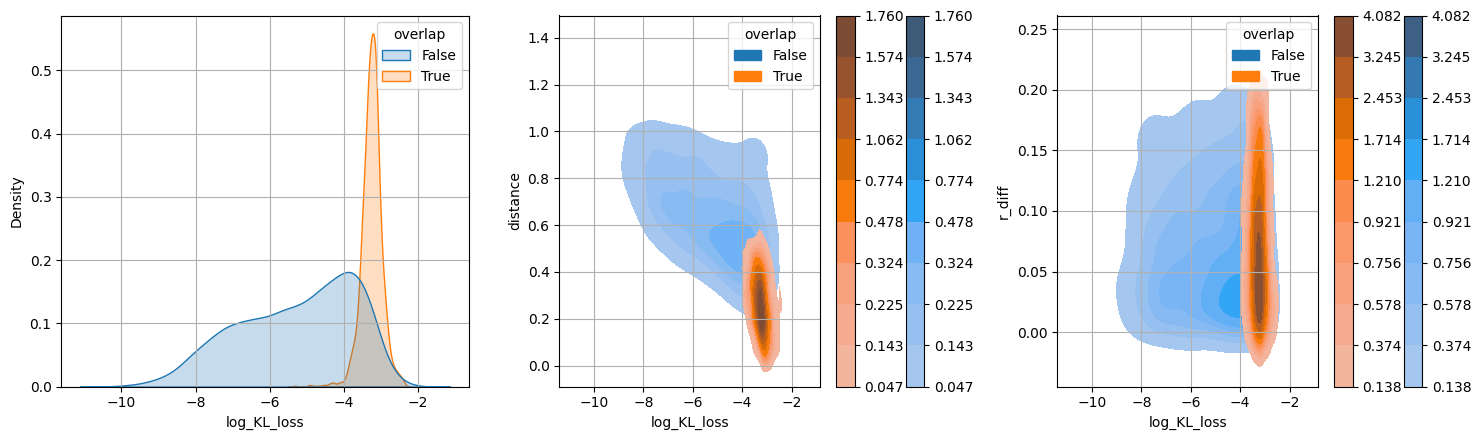

In [40]:
kde_plots()